# MOGP experiment on Finance dataset
## Oil, Gold, NASDAQ, and USD-index dataset

This notebook ilustrate the toolkit use on a real-world finance dataset, taking the weekly price of the Gold, Oil, NASDAQ and USD.

For this 4-output time series we fit three different multioutput Gaussian Processes and show the results.

For each model we optimize we repeat the experiment 5 times, to ensure robustness in the optimization and prediction.


- Oil: Brent daily in USD from https://www.eia.gov/dnav/pet/hist/RBRTEd.htm
- Gold: LMBA gold daily at 10:30AM in USD from https://fred.stlouisfed.org/series/GOLDAMGBD228NLBM
- NASDAQ: adjusted closing price (daily) from https://finance.yahoo.com/quote/%5EIXIC/history?p=%5EIXIC
- USD index: traded weighted on broad currency index from https://fred.stlouisfed.org/series/TWEXB

In [1]:
# execute if not installed
import sys
sys.path.insert(0, '../')

import mogptk
import gpflow

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import datetime 

%reload_ext autoreload
%autoreload 2

# plot config
sns.set_context('paper', font_scale=1.4)
sns.set_style('ticks')
plt.rcParams['figure.figsize'] = (10, 5)

### Load Dataset

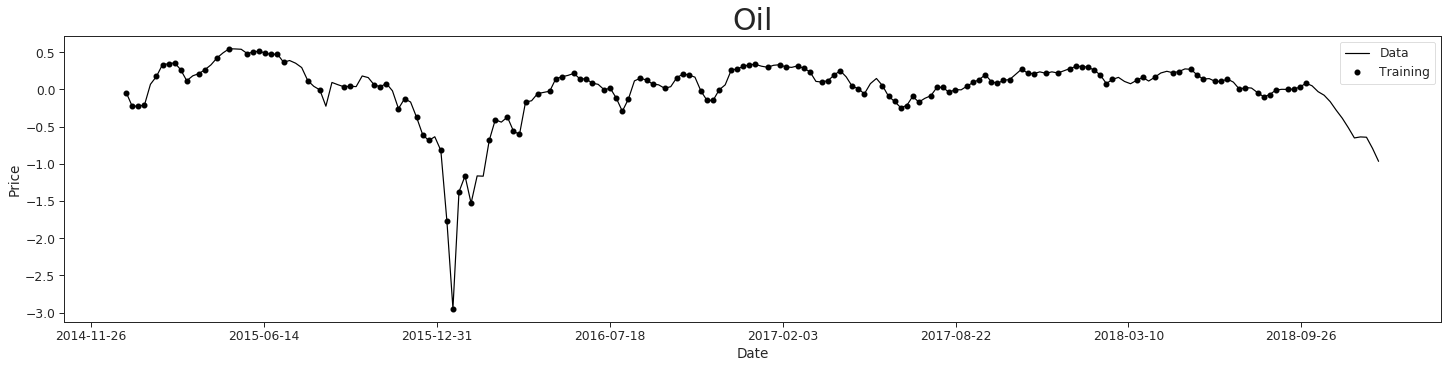

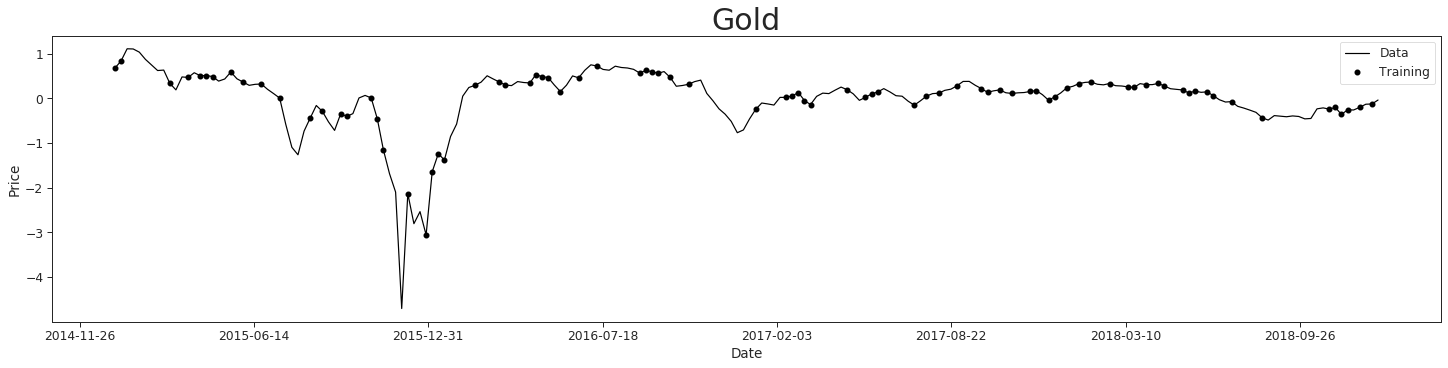

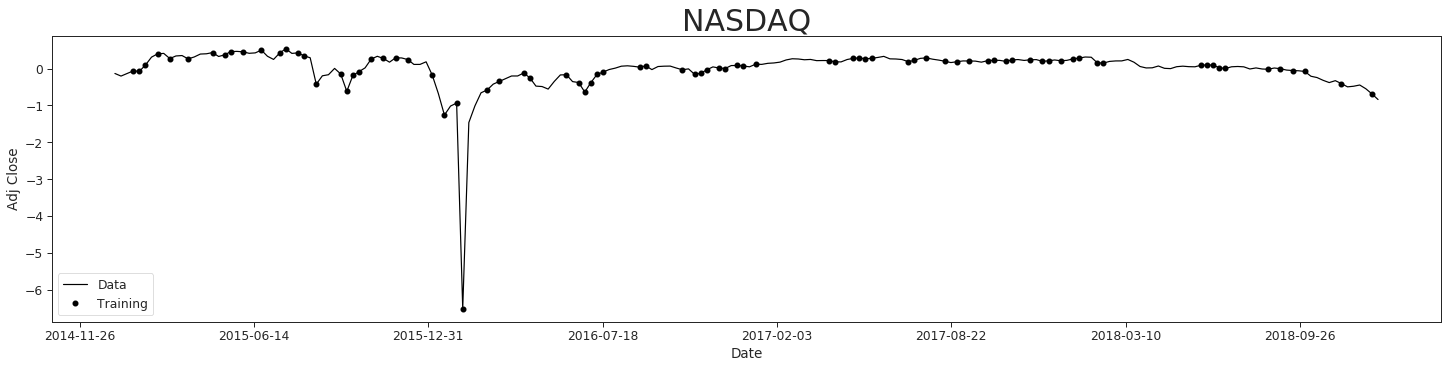

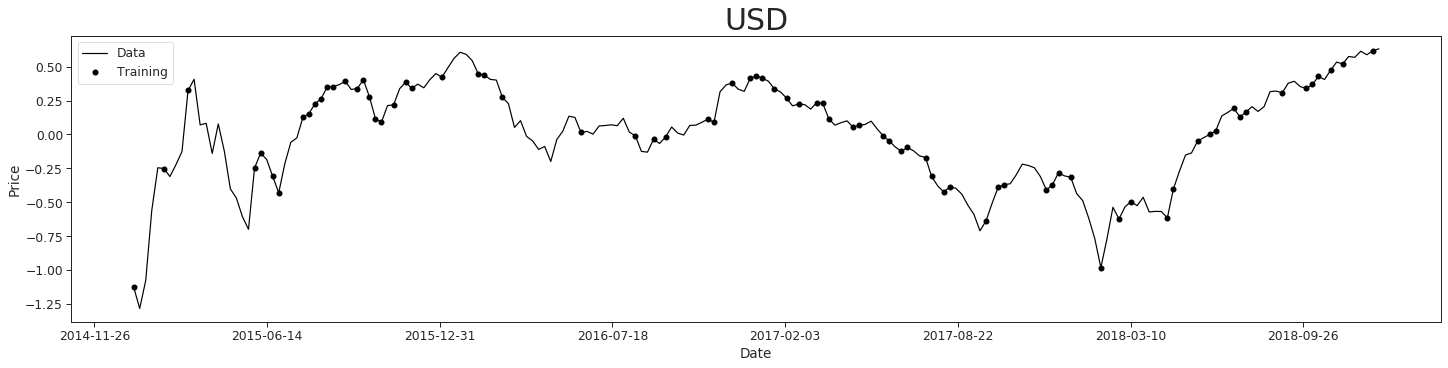

In [2]:
oil = mogptk.LoadCSV('data/gonu/brent-daily.csv',
                     'Date',
                     'Price',
                     name='Oil',
                     format={'Date': mogptk.FormatDate})
gold = mogptk.LoadCSV('data/gonu/lmba-gold-usd-am-daily.csv',
                      'Date',
                      'Price',
                      name='Gold',
                      format={'Date': mogptk.FormatDate})
nasdaq = mogptk.LoadCSV('data/gonu/nasdaq.csv',
                        'Date',
                        'Adj Close',
                        name='NASDAQ',
                        format={'Date': mogptk.FormatDate})
usd = mogptk.LoadCSV('data/gonu/TWEXB.csv',
                     'Date',
                     'Price',
                     name='USD',
                     format={'Date': mogptk.FormatDate})

f_paths = [
    'data/gonu/brent-daily.csv',
    'data/gonu/lmba-gold-usd-am-daily.csv',
    'data/gonu/nasdaq.csv',
    'data/gonu/TWEXB.csv'
          ]
cols = ['Oil', 'Gold' 'NASDAQ', 'USD']

data = [oil, gold, nasdaq, usd]


# Remove points randomly to simulate sensor failure

np.random.seed(1)
for i, channel in enumerate(data):
    channel.filter('2015-01-01', '2018-12-31')
    channel.aggregate('7d')
    
    channel.transform(mogptk.TransformLog)
    channel.transform(mogptk.TransformDetrend)
    
    if i == 1:
        channel.remove_range('2016-11-15', '2017-01-01')
        channel.remove_randomly(pct=0.6)
    if i == 0:
        channel.remove_range('2018-10-05', None)
        channel.remove_randomly(pct=0.3)
    if i == 2:
        channel.remove_randomly(pct=0.6)
    if i == 3:
        channel.remove_range('2016-03-15', '2016-06-01')
        channel.remove_randomly(pct=0.6)
        
    channel.plot()

cols = ['Gold', 'Oil', 'NASDAQ', 'USD']
data = [gold, oil, nasdaq, usd]


x_test = [channel.X[~channel.mask] for channel in data]
y_test = [mogptk.data._detransform(c.transformations, c.X, c.Y)[~c.mask] for c in data]

## MOSM

The first model is the MultiOutput Spectral Mixture kernel

In [3]:
%%time
n_trials = 5

# result containers
mosm_list = []
mosm_mae = np.zeros((n_trials, len(cols)))
mosm_nmae = np.zeros((n_trials, len(cols)))
mosm_rmse = np.zeros((n_trials, len(cols)))
mosm_nrmse = np.zeros((n_trials, len(cols)))

# experiment trials
for n in range(n_trials):
    model_mosm = mogptk.MOSM(data, Q=3)
    model_mosm.build()
    model_mosm.init_params('BNSE')
    
    print('Starting trial', n)
    model_mosm.train(method='L-BFGS-B', maxiter=5000, tol=1e-50)
    print('='*50)
    
    mosm_list.append(model_mosm)
    
    # errors per channel
    error = mogptk.test_errors(model_mosm, x_test=x_test, y_test=y_test)
    
    mosm_mae[n, :] = np.array(error[0])[:, 0]
    mosm_nmae[n, :] = np.array(error[0])[:, 1]
    mosm_rmse[n, :] = np.array(error[0])[:, 2]
    mosm_nrmse[n, :] = np.array(error[0])[:, 3]

Starting trial 0
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: -886.679986
  Number of iterations: 5000
  Number of functions evaluations: 5512
Done in  4.489191059271494  minutes
Finished trial 0
Starting trial 1
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: -881.942678
  Number of iterations: 5000
  Number of functions evaluations: 5499
Done in  4.489185237884522  minutes
Finished trial 1
Starting trial 2
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: -884.062838
  Number of iterations: 5000
  Number of functions evaluations: 5477
Done in  4.5672048926353455  minutes
Finished trial 2
Starting trial 3
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: -

In [4]:
pd.DataFrame(np.c_[mosm_mae.mean(0), mosm_nmae.mean(0), mosm_rmse.mean(0), mosm_nrmse.mean(0),
                             mosm_mae.std(0), mosm_nmae.std(0), mosm_rmse.std(0), mosm_nrmse.std(0)],
                       columns=['MAE', 'nmae', 'RMSE', 'NRMSE', 'MAE std', 'nmae% std', 'RMSE std', 'NRMSE std'])

,MAE,nmae,RMSE,NRMSE,MAE std,nmae% std,RMSE std,NRMSE std
0,15.176993,0.012331,20.876027,0.016961,0.512094,0.000416,0.778732,0.000633
1,1.857501,0.032496,2.767135,0.048409,0.290479,0.005082,0.716022,0.012526
2,121.717145,0.020347,174.529630,0.029175,4.431268,0.000741,9.827263,0.001643
3,0.733045,0.006064,0.991748,0.008204,0.062019,0.000513,0.117897,0.000975


Plot the best model

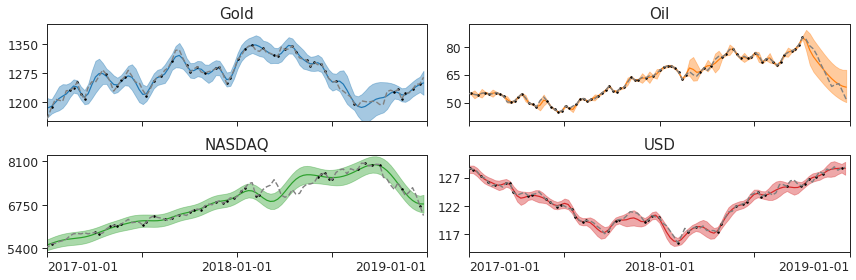

In [6]:
best_mosm = mosm_list[np.argmin(mosm_nmae.mean(1))]
ylims = [(1150, 1400), (40, 92), (5300, 8300), (114, 131)]
f, axarr, _ = mogptk.plot_prediction(best_mosm,
                       grid=(2, 2),
                       names=cols,
                       title='',
                       ylims=ylims,
                       figsize=(12, 4));

yticks = [(1200, 1350), (50, 80), (5400, 8100), (117, 127)]

for i in range(len(cols)):
    axarr[i].set_title(cols[i], fontsize=15)
    axarr[i].set_yticks(np.linspace(yticks[i][0], yticks[i][1], 3))

    channel = best_mosm.data[i]

    xlabels = pd.date_range('2015-01-01', '2018-12-31', periods=9).date
    xticks = [channel.formatters[0]._parse(str(label)) for label in xlabels]
    
    new_xlabels = ['']*9
    xlabels[::2][2:] += datetime.timedelta(days=1)
    new_xlabels[::2] = xlabels[::2]
    
    axarr[i].set_xticks(xticks)
    
    if i>= 2:
         axarr[i].set_xticklabels(new_xlabels)
        
    else:
         axarr[i].set_xticklabels([])
    axarr[i].set_xlim(xticks[4], xticks[-1])
    
    xlabel_list = [item for item in axarr[i].get_xticklabels()]
    
    
    if i>=2:
        xlabel_list[4].set_ha('left')
        xlabel_list[-1].set_ha('right')

plt.tight_layout()
    
# plt.savefig('output/mosm_gonu.pdf', bbox_inches='tight')

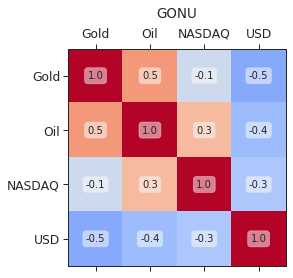

In [12]:
f, ax, im, corr_matrix = best_mosm.plot_correlations()
ax.set_title('GONU', pad=20)
ax.set_yticks(np.arange(4));
ax.set_yticklabels(cols);
ax.set_xticks(np.arange(4));
ax.set_xticklabels(cols);
# plt.savefig('output/corr_gonu_best.pdf', bbox_inches='tight')

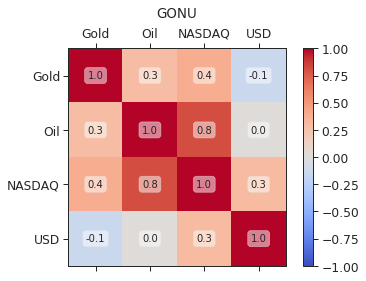

In [10]:
y_all = [mogptk.data._detransform(c.transformations, c.X, c.Y) for c in best_mosm.data]
y_all_array = np.empty((207, 0))
for y in y_all:
    y_all_array = np.c_[y_all_array, y[:207]]

auto_corr = np.corrcoef(y_all_array.T)

color_range = np.abs(auto_corr).max()

f, ax = plt.subplots()
im = ax.matshow(auto_corr, cmap='coolwarm', vmin=-color_range, vmax=color_range)

ax.set_title('GONU', pad=20)
f.colorbar(im)
for (i, j), z in np.ndenumerate(auto_corr):
    ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center', 
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.5, edgecolor='0.9'))

ax.set_yticks(np.arange(4));
ax.set_yticklabels(cols);
ax.set_xticks(np.arange(4));
ax.set_xticklabels(cols);

# plt.savefig('output/autocorr_gonu.pdf', bbox_inches='tight')

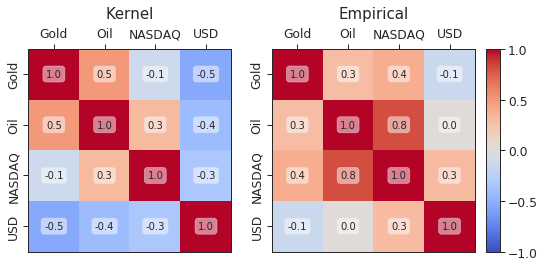

In [40]:
f, axarray = plt.subplots(1, 2, figsize=(8, 5))

color_range = max(np.abs(corr_matrix).max(), np.abs(auto_corr).max())


im = axarray[0].matshow(corr_matrix, cmap='coolwarm', vmin=-color_range, vmax=color_range)
for (i, j), z in np.ndenumerate(corr_matrix):
    axarray[0].text(j, i, '{:0.1f}'.format(z), ha='center', va='center',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.5, edgecolor='0.9'))
axarray[0].set_title('Kernel', y=1.12, fontsize=15)

im = axarray[1].matshow(auto_corr, cmap='coolwarm', vmin=-color_range, vmax=color_range)
ax.set_title('GONU', pad=20)

for (i, j), z in np.ndenumerate(auto_corr):
    axarray[1].text(j, i, '{:0.1f}'.format(z), ha='center', va='center', 
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.5, edgecolor='0.9'))
axarray[1].set_title('Empirical', y=1.12, fontsize=15)

axarray[0].set_yticks(np.arange(4));
axarray[0].set_yticklabels(cols, rotation=90, va='center');
axarray[0].set_xticks(np.arange(4));
axarray[0].set_xticklabels(cols);
axarray[0].xaxis.set_ticks_position('top')

axarray[1].set_yticks(np.arange(4));
axarray[1].set_yticklabels(cols, rotation=90, va='center');
axarray[1].set_xticks(np.arange(4));
axarray[1].set_xticklabels(cols);
axarray[1].xaxis.set_ticks_position('top')

# f.colorbar(im, ax=axarray.ravel().tolist())

cbar_ax = f.add_axes([.92, 0.22, 0.023, 0.563])
f.colorbar(im, cax=cbar_ax)

plt.savefig('output/autocorr_double.pdf', bbox_inches='tight')

In [ ]:
corr_list = []

for model in mosm_list:
    _, _, corr = model.plot_correlations();
    corr_list.append(corr)

In [ ]:
corr_array = np.array(corr_list)
color_range = np.abs(corr_array.mean(0)).max()

f, ax = plt.subplots()
im = ax.matshow(corr_array.mean(0), cmap='coolwarm', vmin=-color_range, vmax=color_range)
f.colorbar(im)
for (i, j), z in np.ndenumerate(corr_array.mean(0)):
    ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center', 
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.5, edgecolor='0.9'))

ax.set_yticks(np.arange(4));
ax.set_yticklabels(cols);
ax.set_xticks(np.arange(4));
ax.set_xticklabels(cols);
# plt.savefig('output/corr_gonu_mean.pdf', bbox_inches='tight')

## CSM

In [41]:
%%time
n_trials = 5

csm_mae = np.zeros((n_trials, len(cols)))
csm_nmae = np.zeros((n_trials, len(cols)))
csm_rmse = np.zeros((n_trials, len(cols)))
csm_nrmse = np.zeros((n_trials, len(cols)))
csm_list = []

for n in range(n_trials):
    model_csm = mogptk.CSM(data, Q=3)
    model_csm.init_params('BNSE')
    
    print('Starting trial', n)
    model_csm.train(method='L-BFGS-B', maxiter=5000, tol=1e-15)
    print('Finished trial', n)
    print('='*50)
    csm_list.append(model_csm)
    
    # errors per channel
    error = mogptk.test_errors(model_csm, x_test=x_test, y_test=y_test)
    
    csm_mae[n, :] = np.array(error[0])[:, 0]
    csm_nmae[n, :] = np.array(error[0])[:, 1]
    csm_rmse[n, :] = np.array(error[0])[:, 2]
    csm_nrmse[n, :] = np.array(error[0])[:, 3]

Starting trial 0
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -827.155591
  Number of iterations: 311
  Number of functions evaluations: 356
Done in  0.34651174942652385  minutes
Finished trial 0
Starting trial 1
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -825.873467
  Number of iterations: 172
  Number of functions evaluations: 211
Done in  0.29031856457392374  minutes
Finished trial 1
Starting trial 2
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -825.486908
  Number of iterations: 411
  Number of functions evaluations: 474
Done in  0.37722214460372927  minutes
Finished trial 2
Starting trial 3
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective fu

In [42]:
pd.DataFrame(np.c_[csm_mae.mean(0), csm_nmae.mean(0), csm_rmse.mean(0), csm_nrmse.mean(0),
                             csm_mae.std(0), csm_nmae.std(0), csm_rmse.std(0), csm_nrmse.std(0)],
                       columns=['MAE', 'nmae', 'RMSE', 'NRMSE', 'MAE std', 'nmae% std', 'RMSE std', 'NRMSE std'])

,MAE,nmae,RMSE,NRMSE,MAE std,nmae% std,RMSE std,NRMSE std
0,22.252619,0.018080,31.511519,0.025602,0.313572,0.000255,0.406814,0.000331
1,1.617869,0.028304,2.006495,0.035102,0.044912,0.000786,0.047007,0.000822
2,138.517534,0.023155,177.798130,0.029722,6.947960,0.001161,11.223888,0.001876
3,0.678273,0.005611,0.862490,0.007135,0.009589,0.000079,0.019852,0.000164


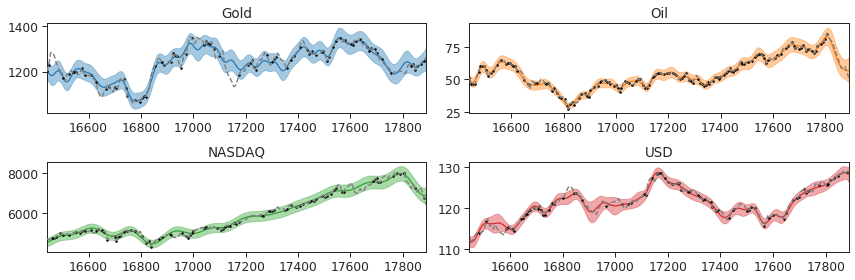

In [43]:
best_csm = csm_list[np.argmin(csm_nmae.mean(1))]
mogptk.plot_prediction(model_csm,grid=(2, 2),
                       names=cols,
                       title='',
                       figsize=(12, 4));

csm = mogptk.CSM(data, Q=3)
csm.init_params()
csm.train(tol=1e-6, maxiter=2000)
csm.print()

csm.predict()
csm.plot_data()

## SM-LMC

In [44]:
%%time
n_trials = 5

smlmc_mae = np.zeros((n_trials, len(cols)))
smlmc_nmae = np.zeros((n_trials, len(cols)))
smlmc_rmse = np.zeros((n_trials, len(cols)))
smlmc_nrmse = np.zeros((n_trials, len(cols)))

for n in range(n_trials):
    print('Trial ', n)
    model_smlmc = mogptk.SM_LMC(data, Q=3)
    model_smlmc.init_params('BNSE')
    print('='*50)
    
    model_smlmc.train(method='L-BFGS-B', maxiter=5000, tol=1e-50)
    
    error = mogptk.test_errors(model_smlmc, x_test=x_test, y_test=y_test)
    
    smlmc_mae[n, :] = np.array(error[0])[:, 0]
    smlmc_nmae[n, :] = np.array(error[0])[:, 1]
    smlmc_rmse[n, :] = np.array(error[0])[:, 2]
    smlmc_nrmse[n, :] = np.array(error[0])[:, 3]

Trial  0
INFO:tensorflow:Optimization terminated with:
  Message: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  Objective function value: -744.821448
  Number of iterations: 1864
  Number of functions evaluations: 2054
Done in  0.737981120745341  minutes
Trial  1
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -744.821447
  Number of iterations: 1614
  Number of functions evaluations: 1775
Done in  0.6622772296269734  minutes
Trial  2
INFO:tensorflow:Optimization terminated with:
  Message: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  Objective function value: -744.821447
  Number of iterations: 1899
  Number of functions evaluations: 2068
Done in  0.7465874473253886  minutes
Trial  3
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: -851.138692
  Number of iterations: 5000
  Number of functions evaluations: 5419
Done in  1.7373921831448

In [45]:
pd.DataFrame(np.c_[smlmc_mae.mean(0), smlmc_nmae.mean(0), smlmc_rmse.mean(0), smlmc_nrmse.mean(0),
                   smlmc_mae.std(0), smlmc_nmae.std(0), smlmc_rmse.std(0), smlmc_nrmse.std(0)],
             columns=['MAE', 'nmae%', 'RMSE', 'NRMSE','MAE std', 'nmae% std', 'RMSE std', 'NRMSE std'])

,MAE,nmae%,RMSE,NRMSE,MAE std,nmae% std,RMSE std,NRMSE std
0,20.262427,0.016463,28.277270,0.022974,1.050651,0.000854,2.158062,0.001753
1,2.278061,0.039853,3.239397,0.056671,0.388390,0.006795,0.675136,0.011811
2,180.180956,0.030120,237.627076,0.039723,21.840844,0.003651,32.552435,0.005442
3,1.529936,0.012656,1.854221,0.015338,0.451317,0.003733,0.533534,0.004413


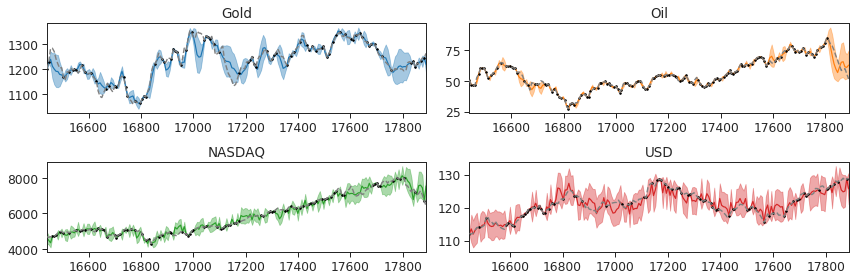

In [46]:
mogptk.plot_prediction(model_smlmc,grid=(2, 2),
                       names=cols,
                       title='',
                       figsize=(12, 4));

smlmc = mogptk.SM_LMC(data, Q=3)
smlmc.init_params()
smlmc.train(tol=1e-6, maxiter=2000)
smlmc.print()

smlmc.predict()
smlmc.plot_data()

# IGP
Independent GP with SM kernels

In [47]:
%%time
n_trials = 5

igp_mae = np.zeros((n_trials, len(cols)))
igp_nmae = np.zeros((n_trials, len(cols)))
igp_rmse = np.zeros((n_trials, len(cols)))
igp_nrmse = np.zeros((n_trials, len(cols)))

for n in range(n_trials):
    print('Trial ', n)
    
    igp_list = []
    
    for i in range(len(cols)):
        model_sm = mogptk.SM(data[i], Q=3)
        model_sm.init_params('BNSE')
        model_sm.train(method='L-BFGS-B', maxiter=5000, tol=1e-50)
        
        igp_list.append(model_sm)
        
        error = mogptk.test_errors(model_sm, x_test=[x_test[i]], y_test=[y_test[i]])
    
        igp_mae[n, i] = np.array(error[0])[:, 0]
        igp_nmae[n, i] = np.array(error[0])[:, 1]
        igp_rmse[n, i] = np.array(error[0])[:, 2]
        igp_nrmse[n, i] = np.array(error[0])[:, 3]
    print('='*50)
    

Trial  0
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -196.702987
  Number of iterations: 69
  Number of functions evaluations: 120
Done in  0.011018109321594239  minutes
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -209.945633
  Number of iterations: 81
  Number of functions evaluations: 138
Done in  0.012185879548390706  minutes
INFO:tensorflow:Optimization terminated with:
  Message: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  Objective function value: -185.733800
  Number of iterations: 54
  Number of functions evaluations: 117
Done in  0.010357054074605306  minutes
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -244.523049
  Number of iterations: 67
  Number of functions evaluations: 99
Done in  0.00978152354558309  minute

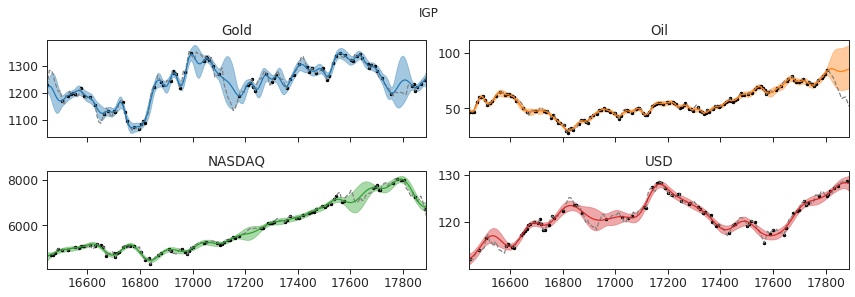

In [48]:
f, axarr = plt.subplots(2, 2, sharex=True, figsize=(12, 4))
axarr = axarr.reshape(-1)

for i in range(len(cols)):
    c = igp_list[i].data[0]
    x_train = c.X[c.mask]
    y_train = mogptk.data._detransform(c.transformations, c.X[c.mask], c.Y[c.mask])
    
    x_all = c.X
    y_all = mogptk.data._detransform(c.transformations, c.X, c.Y)
    
    x_pred = c.X
    mean_pred, lower_ci, upper_ci = igp_list[i].predict([x_pred])
    
    axarr[i].plot(x_train[:, 0], y_train, '.k', label='Train', )
    axarr[i].plot(x_all[:, 0], y_all, '--', label='Test', c='gray')

    axarr[i].plot(x_pred[:, 0], mean_pred[0], label='Post.Mean', c=sns.color_palette()[i%10])
    axarr[i].fill_between(x_pred[:, 0].reshape(-1),
                          lower_ci[0],
                          upper_ci[0],
                          label='95% c.i',
                          color=sns.color_palette()[i%10],
                          alpha=0.4)

    axarr[i].set_xlim(x_all[0]-1, x_all[-1])

    # set channels name
    
    axarr[i].set_title(cols[i])

plt.suptitle('IGP', y=1.02)
plt.tight_layout()

## Results

In [30]:
print(mosm_nmae[:, :].mean(), csm_nmae[:, :].mean(), smlmc_nmae[:, :].mean(), igp_nmae[:, :].mean())

1.774853646507999 1.9312200711974878 2.314295392885879 2.773855778714582


In [31]:
print(mosm_nmae[:, :].std(), csm_nmae[:, :].std(), smlmc_nmae[:, :].std(), igp_nmae[:, :].std())

1.0579814696355159 0.8996290149216416 1.1709134456187058 2.657399899451433


In [32]:
print(mosm_nrmse[:, :].mean(), csm_nrmse[:, :].mean(), smlmc_nrmse[:, :].mean(), igp_nrmse[:, :].mean()

0.02557535910895493 0.024466266630046744 0.03075072127981131 0.05071179393123095


In [33]:
print(mosm_nrmse[:, :].std(), csm_nrmse[:, :].std(), smlmc_nrmse[:, :].std(), igp_nrmse[:, :].std())

0.017544631391744295 0.010585363728321365 0.016751272417778334 0.05792883469221094


In [111]:
print('mosm nMAE {:.3e} pm {:.3e} | mosm nRMSE {:.3e} pm {:.3e}'.format(
        mosm_nmae.mean(1).mean(),
        mosm_nmae.mean(1).std(),
        mosm_nrmse.mean(1).mean(),
        mosm_nrmse.mean(1).std(),
    )
     )

mosm nMAE 1.781e-02 pm 1.477e-03 | mosm nRMSE 2.569e-02 pm 3.598e-03


In [113]:
print('csm nMAE {:.3e} pm {:.3e} | csm nRMSE {:.3e} pm {:.3e}'.format(
        csm_nmae.mean(1).mean(),
        csm_nmae.mean(1).std(),
        csm_nrmse.mean(1).mean(),
        csm_nrmse.mean(1).std(),
    )
     )

csm nMAE 1.879e-02 pm 1.523e-04 | csm nRMSE 2.439e-02 pm 5.802e-04


In [114]:
print('smlmc nMAE {:.3e} pm {:.3e} | smlmc nRMSE {:.3e} pm {:.3e}'.format(
        smlmc_nmae.mean(1).mean(),
        smlmc_nmae.mean(1).std(),
        smlmc_nrmse.mean(1).mean(),
        smlmc_nrmse.mean(1).std(),
    )
     )

smlmc nMAE 2.477e-02 pm 3.734e-03 | smlmc nRMSE 3.368e-02 pm 5.813e-03


In [116]:
print('igp nMAE {:.3e} pm {:.3e} | igp nRMSE {:.3e} pm {:.3e}'.format(
        igp_nmae.mean(1).mean(),
        igp_nmae.mean(1).std(),
        igp_nrmse.mean(1).mean(),
        igp_nrmse.mean(1).std(),
    )
     )

igp nMAE 2.817e-02 pm 3.469e-18 | igp nRMSE 5.071e-02 pm 0.000e+00


In [91]:
mosm_errors = mogptk.test_errors(*mosm_list, x_test=x_test, y_test=y_test, raw_errors=True)

In [118]:
mosm_nmae2 = np.zeros(5)
mosm_nrmse2 = np.zeros(5)

for n, error in enumerate(mosm_errors):
    mosm_nmae2[n] = np.abs(error[1][-stop:]).mean() / y_test[1][-stop:].mean()
    mosm_nrmse2[n] = np.sqrt((error[1][-stop:]**2).mean()) / y_test[1][-stop:].mean()
    
print('mosm nMAE {:.3e} pm {:.3e} | mosm nRMSE {:.3e} pm {:.3e}'.format(
        mosm_nmae2.mean(),
        mosm_nmae2.std(),
        mosm_nrmse2.mean(),
        mosm_nrmse2.std(),
    )
     )

mosm nMAE 6.242e-02 pm 2.309e-02 | mosm nRMSE 7.870e-02 pm 2.987e-02
